In [30]:
import numpy as np
from scipy.sparse import spdiags
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from scipy.fftpack import fft2, ifft2
from scipy.integrate import solve_ivp
from scipy.linalg import lu, solve_triangular
import time
from scipy.sparse.linalg import bicgstab
from scipy.sparse.linalg import gmres
import imageio
from matplotlib.animation import FuncAnimation

In [31]:
L = 10
n = 64
def onediag(n):
    N = np.ones(n**2)
    for i in range(0, n):
        N[n * (i + 1) - 1] = 0
    return N

def zerodiag(n):
    N = np.zeros(n**2)
    for i in range(0, n):
        N[n * i] = 1
    return N

data = np.array([-4*np.ones(n**2), onediag(n)[::-1], onediag(n), zerodiag(n)[::-1], zerodiag(n), np.ones(n**2), np.ones(n**2),  np.ones(n**2), np.ones(n**2)])
diags = [0, 1, -1, n - 1, 1 - n, n, -n, n**2 - n, n - n**2]
A0 = spdiags(data, diags, n**2, n**2).toarray()
A = A0/(((L-(-L))/n)**2)
A[0, 0] = 2

data = np.array([np.ones(n**2), -np.ones(n**2), -np.ones(n**2), np.ones(n**2)])
diags = [n, -n, n*(n-1), -n*(n-1)]
A0 = spdiags(data, diags, n**2, n**2).toarray()
B = A0/(2*((L-(-L))/n))

data = np.array([onediag(n)[::-1], -onediag(n), -zerodiag(n)[::-1], zerodiag(n)])
diags = [1, -1, n-1, 1-n]
A0 = spdiags(data, diags, n**2, n**2).toarray()
C = A0/(2*((L-(-L))/n))

print(A.shape, B.shape, C.shape)

(4096, 4096) (4096, 4096) (4096, 4096)


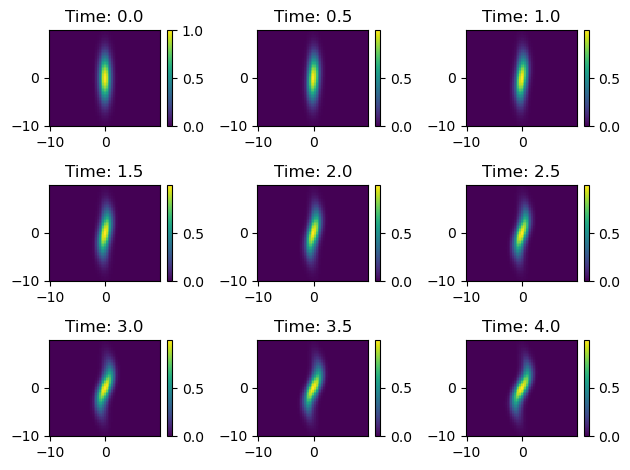

Elapsed time: 0.49 seconds
(4096, 9)
[[2.50656748e-46 3.57996136e-45 1.88106144e-44 ... 1.89120623e-42
  4.77616101e-42 1.13546131e-41]
 [1.17762859e-43 6.53684714e-43 2.62060728e-42 ... 1.58866490e-40
  3.55915954e-40 7.45533247e-40]
 [4.55107657e-41 1.93087628e-40 6.43663355e-40 ... 2.48966551e-38
  5.07459635e-38 9.69185374e-38]
 ...
 [1.96785570e-38 1.23636238e-37 5.46906656e-37 ... 4.35977114e-35
  1.02335874e-34 2.22858322e-34]
 [6.19028421e-41 5.34124949e-40 2.93882031e-39 ... 3.68664229e-37
  9.45501433e-37 2.23512843e-36]
 [1.60178709e-43 1.99879166e-42 1.41268009e-41 ... 2.80496038e-39
  7.96285821e-39 2.07493092e-38]]


In [32]:
tspan = np.linspace(0, 4, 9)
tshoot = [0, 4]
nu = 0.001
Lx, Ly = 20, 20
nx, ny = 64, 64
N = nx * ny

x2 = np.linspace(-Lx/2, Lx/2, nx + 1)
x = x2[:nx]
y2 = np.linspace(-Ly/2, Ly/2, ny + 1)
y = y2[:ny]
X, Y = np.meshgrid(x, y)
w = 1 * np.exp(- X**2 - Y**2/20)

kx = (2 * np.pi / Lx) * np.concatenate((np.arange(0, nx/2), np.arange(-nx/2, 0)))
kx[0] = 1e-6
ky = (2 * np.pi / Ly) * np.concatenate((np.arange(0, ny/2), np.arange(-ny/2, 0)))
ky[0] = 1e-6
KX, KY = np.meshgrid(kx, ky)
K = KX**2 + KY**2

start_time = time.time()
def spc_rhs(t, wt2, nx, ny, N, K, nu):
    wtc = wt2[0:N]
    wtN = wtc.reshape(N)
    wt = fft2(wtc.reshape((nx,ny)))
    psit = np.real(ifft2(-wt / K))
    psitN = psit.reshape(N)
    rhs = (nu * np.dot(A, wtN) - np.dot(B, psitN) * np.dot(C, wtN) + np.dot(C, psitN) * np.dot(B, wtN)).reshape(N)
    return rhs

w0 = w.reshape(N)
wtsol = solve_ivp(spc_rhs, tshoot, w0, t_eval = tspan, args=(nx, ny, N, K, nu), method = 'RK45')
end_time = time.time()
A1 = wtsol.y
for j, t in enumerate(tspan):
    wsol = wtsol.y[:,j].reshape((nx, ny))
    plt.subplot(3, 3, j+1)
    plt.pcolor(x, y, wsol)
    plt.title(f'Time: {t}')
    plt.colorbar()

plt.tight_layout()
plt.show()

elapsed_time = end_time- start_time
print(f"Elapsed time: {elapsed_time:.2f} seconds")
print(A1.shape)
print(A1)

In [33]:
image = []
for j, t in enumerate(tspan):
    wsol = wtsol.y[:N,j].reshape((nx, ny))
    plt.pcolor(x, y, wsol)
    plt.colorbar()
    file_name = f"frame_{j}.png"
    plt.savefig(file_name)
    images.append(imageio.imread(file_name)) 
    plt.close() 
    

imageio.mimsave("initial_condition_given.gif", images, duration=0.5)

C:\Users\27963\AppData\Local\Temp\ipykernel_27928\1128881523.py:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(file_name))


Elapsed time: 12.96 seconds
(4096, 9)
[[ 2.50656748e-46 -1.78784704e-36  1.02706391e-36 ... -5.76806489e-26
  -6.68287054e-25  3.02050167e-24]
 [ 1.17762859e-43 -2.26093387e-29  1.85614646e-29 ... -1.48306461e-19
  -7.82424220e-19  1.67449651e-18]
 [ 4.55107657e-41 -4.24661881e-29  3.48720993e-29 ... -2.20165937e-20
  -2.91637720e-19  1.23961335e-18]
 ...
 [ 1.96785570e-38  7.20814729e-28 -6.58759786e-28 ...  4.01674620e-20
   1.34371413e-19 -8.94163775e-19]
 [ 6.19028421e-41  1.69117621e-28 -1.49205998e-28 ...  3.00460834e-20
   1.76009486e-19 -9.80736832e-19]
 [ 1.60178709e-43  5.05834665e-29 -4.38046443e-29 ...  2.47633369e-20
   1.15181522e-20  3.12761254e-20]]


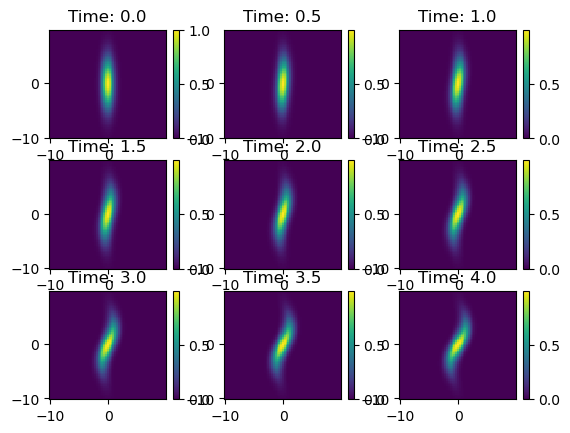

In [34]:
tspan = np.linspace(0, 4, 9)
tshoot = [0, 4]
nu = 0.001
Lx, Ly = 20, 20
nx, ny = 64, 64
N = nx * ny
A[0, 0] = 2

x2 = np.linspace(-Lx/2, Lx/2, nx + 1)
x = x2[:nx]
y2 = np.linspace(-Ly/2, Ly/2, ny + 1)
y = y2[:ny]
X, Y = np.meshgrid(x, y)
w = 1 * np.exp(- X**2 - Y**2/20)

start_time = time.time()
def spc_rhs2(t, wt2, nx, ny, N, nu):
    wtc = wt2[0:N]
    wt = wtc.reshape((nx, ny)) 
    wtN = wt.reshape(N)
    psit = np.linalg.solve(A, wtN)
    psitN = psit.reshape(N)
    rhs = (nu * np.dot(A, wtN) - np.dot(B, psitN) * np.dot(C, wtN) + np.dot(C, psitN) * np.dot(B, wtN)).reshape(N)
    return rhs

wt0 = w.reshape(N)
wtsol = solve_ivp(spc_rhs2, tshoot, wt0, t_eval = tspan, args=(nx, ny, N, nu), method = 'RK45')
end_time = time.time()
A2 = wtsol.y
for j, t in enumerate(tspan):
    wsol = wtsol.y[:N,j].reshape((nx, ny))

    plt.subplot(3, 3, j+1)
    plt.pcolor(x, y, wsol)
    plt.title(f'Time: {t}')
    plt.colorbar()

elapsed_time = end_time- start_time
print(f"Elapsed time: {elapsed_time:.2f} seconds")
print(A2.shape)
print(A2)

Elapsed time: 2.82 seconds
(4096, 9)
[[ 2.50656748e-46 -1.78784704e-36  1.02706391e-36 ... -5.76806489e-26
  -6.68287054e-25  3.02050167e-24]
 [ 1.17762859e-43 -2.26093387e-29  1.85614646e-29 ... -1.48306461e-19
  -7.82424220e-19  1.67449651e-18]
 [ 4.55107657e-41 -4.24661881e-29  3.48720993e-29 ... -2.20165937e-20
  -2.91637720e-19  1.23961335e-18]
 ...
 [ 1.96785570e-38  7.20814729e-28 -6.58759786e-28 ...  4.01674620e-20
   1.34371413e-19 -8.94163775e-19]
 [ 6.19028421e-41  1.69117621e-28 -1.49205998e-28 ...  3.00460834e-20
   1.76009486e-19 -9.80736832e-19]
 [ 1.60178709e-43  5.05834665e-29 -4.38046443e-29 ...  2.47633369e-20
   1.15181522e-20  3.12761254e-20]]


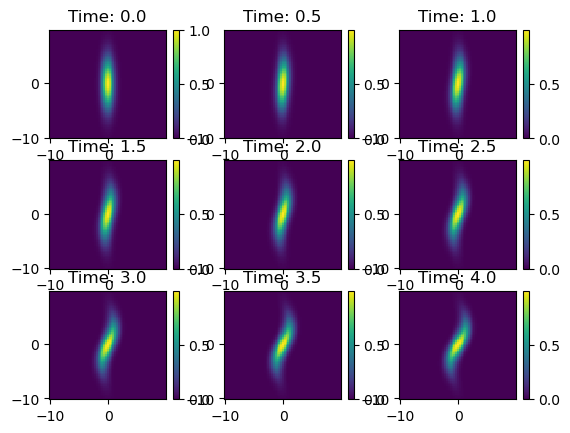

In [35]:
tspan = np.linspace(0, 4, 9)
tshoot = [0, 4]
nu = 0.001
Lx, Ly = 20, 20
nx, ny = 64, 64
N = nx * ny
A[0, 0] = 2

x2 = np.linspace(-Lx/2, Lx/2, nx + 1)
x = x2[:nx]
y2 = np.linspace(-Ly/2, Ly/2, ny + 1)
y = y2[:ny]
X, Y = np.meshgrid(x, y)
w = 1 * np.exp(- X**2 - Y**2/20)

start_time = time.time()
P, L, U = lu(A)
def spc_rhs3(t, wt2, nx, ny, N, nu):
    wtc = wt2[0:N]
    wt = wtc.reshape((nx, ny)) 
    wtN = wt.reshape(N)
    Pb = np.dot(P, wtN)
    y = solve_triangular(L, Pb, lower=True)
    psit = solve_triangular(U, y)
    psitN = psit.reshape(N)
    rhs = (nu * np.dot(A, wtN) - np.dot(B, psitN) * np.dot(C, wtN) + np.dot(C, psitN) * np.dot(B, wtN)).reshape(N)
    return rhs

wt0 = w.reshape(N)
wtsol = solve_ivp(spc_rhs3, tshoot, wt0, t_eval = tspan, args=(nx, ny, N, nu), method = 'RK45')
end_time = time.time()
A3 = wtsol.y
for j, t in enumerate(tspan):
    wsol = wtsol.y[:N,j].reshape((nx, ny))
    plt.subplot(3, 3, j+1)
    plt.pcolor(x, y, wsol)
    plt.title(f'Time: {t}')
    plt.colorbar()

elapsed_time = end_time- start_time
print(f"Elapsed time: {elapsed_time:.2f} seconds")
print(A3.shape)
print(A3)

Elapsed time: 80.58 seconds
(4096, 9)
[[ 2.50656748e-46 -1.97010096e-37  2.58905271e-37 ... -5.12538536e-25
  -1.12750741e-25  2.41971519e-24]
 [ 1.17762859e-43 -2.00848049e-30  2.00892334e-30 ... -1.66767850e-18
   8.17713390e-19  1.33430673e-18]
 [ 4.55107657e-41 -3.76343002e-30  3.52360494e-30 ... -1.87789618e-19
  -7.78371703e-20  9.69459667e-19]
 ...
 [ 1.96785570e-38  5.87613440e-29 -2.13457440e-29 ...  4.38908257e-19
  -2.74339676e-19 -7.34264070e-19]
 [ 6.19028421e-41  1.41854766e-29 -7.57833228e-30 ...  3.07431142e-19
  -1.25569272e-19 -7.82565708e-19]
 [ 1.60178709e-43  4.31106944e-30 -2.88226333e-30 ...  3.03349856e-19
  -2.61787476e-19  2.95438766e-20]]


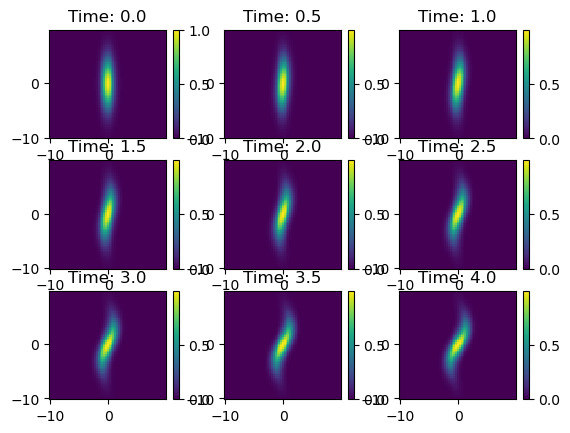

In [36]:
tspan = np.linspace(0, 4, 9)
tshoot = [0, 4]
nu = 0.001
Lx, Ly = 20, 20
nx, ny = 64, 64
N = nx * ny
A[0, 0] = 2

x2 = np.linspace(-Lx/2, Lx/2, nx + 1)
x = x2[:nx]
y2 = np.linspace(-Ly/2, Ly/2, ny + 1)
y = y2[:ny]
X, Y = np.meshgrid(x, y)
w = 1 * np.exp(- X**2 - Y**2/20)

start_time = time.time()
def spc_rhs4(t, wt2, nx, ny, N, nu):
    wtc = wt2[0:N]
    wt = wtc.reshape((nx, ny)) 
    wtN = wt.reshape(N)
    psit, info = bicgstab(A, wtN)
    psitN = psit.reshape(N)
    rhs = (nu * np.dot(A, wtN) - np.dot(B, psitN) * np.dot(C, wtN) + np.dot(C, psitN) * np.dot(B, wtN)).reshape(N)
    return rhs

wt0 = w.reshape(N)
wtsol = solve_ivp(spc_rhs4, tshoot, wt0, t_eval = tspan, args=(nx, ny, N, nu), method = 'RK45')
end_time = time.time()
A4 = wtsol.y
for j, t in enumerate(tspan):
    wsol = wtsol.y[:N,j].reshape((nx, ny))
    plt.subplot(3, 3, j+1)
    plt.pcolor(x, y, wsol)
    plt.title(f'Time: {t}')
    plt.colorbar()

elapsed_time = end_time- start_time
print(f"Elapsed time: {elapsed_time:.2f} seconds")
print(A4.shape)
print(A4)

Elapsed time: 0.58 seconds
(4096, 9)
[[2.50656748e-46 1.02564421e-44 4.96836009e-44 ... 1.18127413e-42
  3.05143453e-42 7.02218601e-42]
 [1.17762859e-43 9.66648726e-43 3.75422081e-42 ... 1.12368373e-40
  2.56050390e-40 5.36620629e-40]
 [4.55107657e-41 2.16937839e-40 6.89411569e-40 ... 1.88817071e-38
  3.88957267e-38 7.52499100e-38]
 ...
 [1.96785570e-38 6.75352767e-38 1.81573607e-37 ... 3.71357842e-36
  6.99756805e-36 1.25692065e-35]
 [6.19028421e-41 2.92324718e-40 9.24065626e-40 ... 2.52705383e-38
  5.18631285e-38 1.00008582e-37]
 [1.60178709e-43 1.29203535e-42 4.98339039e-42 ... 1.50584471e-40
  3.41717731e-40 7.13664991e-40]]


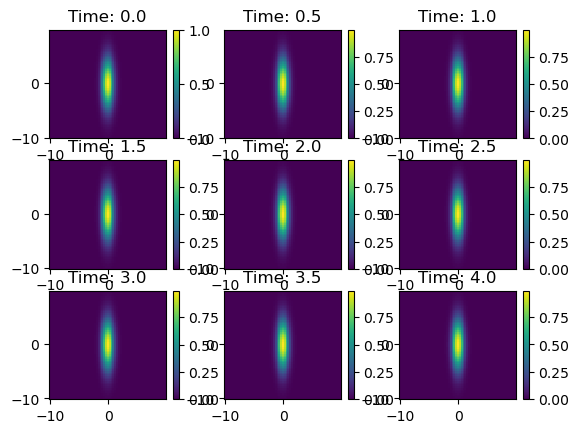

In [37]:
tspan = np.linspace(0, 4, 9)
tshoot = [0, 4]
nu = 0.001
Lx, Ly = 20, 20
nx, ny = 64, 64
N = nx * ny
A[0, 0] = 2

x2 = np.linspace(-Lx/2, Lx/2, nx + 1)
x = x2[:nx]
y2 = np.linspace(-Ly/2, Ly/2, ny + 1)
y = y2[:ny]
X, Y = np.meshgrid(x, y)
w = 1 * np.exp(- X**2 - Y**2/20)

start_time = time.time()
def spc_rhs5(t, wt2, nx, ny, N, nu):
    wtc = wt2[0:N]
    wt = wtc.reshape((nx, ny)) 
    wtN = wt.reshape(N)
    psit, info = gmres(A, wtN, tol = 1)
    psitN = psit.reshape(N)
    rhs = (nu * np.dot(A, wtN) - np.dot(B, psitN) * np.dot(C, wtN) + np.dot(C, psitN) * np.dot(B, wtN)).reshape(N)
    return rhs

wt0 = w.reshape(N)
wtsol = solve_ivp(spc_rhs5, tshoot, wt0, t_eval = tspan, args=(nx, ny, N, nu), method = 'RK45')
end_time = time.time()
A5 = wtsol.y
for j, t in enumerate(tspan):
    wsol = wtsol.y[:N,j].reshape((nx, ny))
    plt.subplot(3, 3, j+1)
    plt.pcolor(x, y, wsol)
    plt.title(f'Time: {t}')
    plt.colorbar()

elapsed_time = end_time- start_time
print(f"Elapsed time: {elapsed_time:.2f} seconds")
print(A5.shape)
print(A5)

In [38]:
L = 10
def gaussian_vortex(x0, y0, a, sigma, X, Y):
    return a * np.exp(-((X - x0)**2 + (Y - y0)**2) / sigma**2)

# 1. 两个相反“电荷”的高斯涡旋
def initial_condition_opposite_vortices(X, Y):
    omega = np.zeros_like(X)
    omega += gaussian_vortex(-L/2, 0, 5, 5, X, Y)  
    omega += gaussian_vortex(L/2, 0, -5, 5, X, Y) 
    return omega

# 2. 两个相同“电荷”的高斯涡旋
def initial_condition_same_vortices(X, Y):
    omega = np.zeros_like(X)
    omega += gaussian_vortex(-L/2, 0, 5, 5, X, Y) 
    omega += gaussian_vortex(L/2, 0, 5, 5, X, Y)  
    return omega

# 3. 两对相反“电荷”的涡旋
def initial_condition_two_pairs(X, Y):
    omega = np.zeros_like(X)
    omega += gaussian_vortex(-L/2, -L/2, 5, 5, X, Y)  
    omega += gaussian_vortex(-L/2, L/2, -5, 5, X, Y)  
    omega += gaussian_vortex(L/2, -L/2, -5, 5, X, Y)  
    omega += gaussian_vortex(L/2, L/2, 5, 5, X, Y)  
    return omega


def initial_condition_random_vortices(X, Y, N_vortices=15):
    omega = np.zeros_like(X)
    for _ in range(N_vortices):
        x0 = np.random.uniform(-L, L)
        y0 = np.random.uniform(L, L)
        A = np.random.uniform(-5, 5) 
        sigma = np.random.uniform(1, 5)  
        omega += gaussian_vortex(x0, y0, A, sigma, X, Y)
    return omega

In [39]:
tspan = np.linspace(0, 4, 9)
tshoot = [0, 4]
nu = 0.001
Lx, Ly = 20, 20
nx, ny = 64, 64
N = nx * ny

x2 = np.linspace(-Lx/2, Lx/2, nx + 1)
x = x2[:nx]
y2 = np.linspace(-Ly/2, Ly/2, ny + 1)
y = y2[:ny]
X, Y = np.meshgrid(x, y)
w = initial_condition_opposite_vortices(X, Y)

kx = (2 * np.pi / Lx) * np.concatenate((np.arange(0, nx/2), np.arange(-nx/2, 0)))
kx[0] = 1e-6
ky = (2 * np.pi / Ly) * np.concatenate((np.arange(0, ny/2), np.arange(-ny/2, 0)))
ky[0] = 1e-6
KX, KY = np.meshgrid(kx, ky)
K = KX**2 + KY**2

start_time = time.time()
def spc_rhs(t, wt2, nx, ny, N, K, nu):
    wtc = wt2[0:N]
    wtN = wtc.reshape(N)
    wt = fft2(wtc.reshape((nx,ny)))
    psit = np.real(ifft2(-wt / K))
    psitN = psit.reshape(N)
    rhs = (nu * np.dot(A, wtN) - np.dot(B, psitN) * np.dot(C, wtN) + np.dot(C, psitN) * np.dot(B, wtN)).reshape(N)
    return rhs

w0 = w.reshape(N)
wtsol = solve_ivp(spc_rhs, tshoot, w0, t_eval = tspan, args=(nx, ny, N, K, nu), method = 'RK45')
end_time = time.time()
A6 = wtsol.y
images = []
for j, t in enumerate(tspan):
    wsol = wtsol.y[:N,j].reshape((nx, ny))
    plt.pcolor(x, y, wsol)
    plt.colorbar()
    file_name = f"frame_{j}.png"
    plt.savefig(file_name)
    images.append(imageio.imread(file_name))
    plt.close() 
    

imageio.mimsave("initial_condition_opposite_vortices.gif", images, duration=0.5)
elapsed_time = end_time- start_time
print(f"Elapsed time: {elapsed_time:.2f} seconds")
print(A6.shape)
print(A6)

C:\Users\27963\AppData\Local\Temp\ipykernel_27928\1694235148.py:43: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(file_name))


Elapsed time: 6.81 seconds
(4096, 9)
[[ 0.03367843  0.12864157  0.80382985 ...  0.07469029  0.09375176
   0.79475807]
 [ 0.03801026  0.1533969   1.09528041 ...  0.07907825  0.10924313
   1.03147687]
 [ 0.04256426  0.16419523  1.13053102 ...  0.12733932  0.09673005
   1.32993891]
 ...
 [-0.0604865  -0.22403344 -1.41048119 ... -0.11522835 -0.1405274
  -1.44307417]
 [-0.05444052 -0.21125162 -1.18836055 ... -0.07657975 -0.15046947
  -1.09506538]
 [-0.04861586 -0.16482265 -0.58574045 ... -0.07709735 -0.12736075
  -0.58790557]]


In [40]:
tspan = np.linspace(0, 4, 9)
tshoot = [0, 4]
nu = 0.001
Lx, Ly = 20, 20
nx, ny = 64, 64
N = nx * ny

x2 = np.linspace(-Lx/2, Lx/2, nx + 1)
x = x2[:nx]
y2 = np.linspace(-Ly/2, Ly/2, ny + 1)
y = y2[:ny]
X, Y = np.meshgrid(x, y)
w = initial_condition_same_vortices(X, Y)

kx = (2 * np.pi / Lx) * np.concatenate((np.arange(0, nx/2), np.arange(-nx/2, 0)))
kx[0] = 1e-6
ky = (2 * np.pi / Ly) * np.concatenate((np.arange(0, ny/2), np.arange(-ny/2, 0)))
ky[0] = 1e-6
KX, KY = np.meshgrid(kx, ky)
K = KX**2 + KY**2

start_time = time.time()
def spc_rhs(t, wt2, nx, ny, N, K, nu):
    wtc = wt2[0:N]
    wtN = wtc.reshape(N)
    wt = fft2(wtc.reshape((nx,ny)))
    psit = np.real(ifft2(-wt / K))
    psitN = psit.reshape(N)
    rhs = (nu * np.dot(A, wtN) - np.dot(B, psitN) * np.dot(C, wtN) + np.dot(C, psitN) * np.dot(B, wtN)).reshape(N)
    return rhs

w0 = w.reshape(N)
wtsol = solve_ivp(spc_rhs, tshoot, w0, t_eval = tspan, args=(nx, ny, N, K, nu), method = 'RK45')
end_time = time.time()
A7 = wtsol.y
images = []
for j, t in enumerate(tspan):
    wsol = wtsol.y[:N,j].reshape((nx, ny))
    plt.pcolor(x, y, wsol)
    plt.colorbar()
    file_name = f"frame_{j}.png"
    plt.savefig(file_name)
    images.append(imageio.imread(file_name))
    plt.close() 
    

imageio.mimsave("initial_condition_same_vortices.gif", images, duration=0.5)
elapsed_time = end_time- start_time
print(f"Elapsed time: {elapsed_time:.2f} seconds")
print(A7.shape)
print(A7)

C:\Users\27963\AppData\Local\Temp\ipykernel_27928\4103987337.py:43: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(file_name))


Elapsed time: 4.14 seconds
(4096, 9)
[[0.03370104 0.03456988 0.03545875 ... 0.03932794 0.04030582 0.04126237]
 [0.03804302 0.03807546 0.03799517 ... 0.03813409 0.03875598 0.03945548]
 [0.04261137 0.04271478 0.04264107 ... 0.04170289 0.04281329 0.0442734 ]
 ...
 [0.06057248 0.05986905 0.05951838 ... 0.05511305 0.05352653 0.05201023]
 [0.05450077 0.05526288 0.05548454 ... 0.05104161 0.05030321 0.04963508]
 [0.04865776 0.05143558 0.05384612 ... 0.05074055 0.0484465  0.0470632 ]]


In [41]:
tspan = np.linspace(0, 4, 9)
tshoot = [0, 4]
nu = 0.001
Lx, Ly = 20, 20
nx, ny = 64, 64
N = nx * ny

x2 = np.linspace(-Lx/2, Lx/2, nx + 1)
x = x2[:nx]
y2 = np.linspace(-Ly/2, Ly/2, ny + 1)
y = y2[:ny]
X, Y = np.meshgrid(x, y)
w = initial_condition_two_pairs(X, Y)

kx = (2 * np.pi / Lx) * np.concatenate((np.arange(0, nx/2), np.arange(-nx/2, 0)))
kx[0] = 1e-6
ky = (2 * np.pi / Ly) * np.concatenate((np.arange(0, ny/2), np.arange(-ny/2, 0)))
ky[0] = 1e-6
KX, KY = np.meshgrid(kx, ky)
K = KX**2 + KY**2

start_time = time.time()
def spc_rhs(t, wt2, nx, ny, N, K, nu):
    wtc = wt2[0:N]
    wtN = wtc.reshape(N)
    wt = fft2(wtc.reshape((nx,ny)))
    psit = np.real(ifft2(-wt / K))
    psitN = psit.reshape(N)
    rhs = (nu * np.dot(A, wtN) - np.dot(B, psitN) * np.dot(C, wtN) + np.dot(C, psitN) * np.dot(B, wtN)).reshape(N)
    return rhs

w0 = w.reshape(N)
wtsol = solve_ivp(spc_rhs, tshoot, w0, t_eval = tspan, args=(nx, ny, N, K, nu), method = 'RK45')
end_time = time.time()
A8 = wtsol.y
images = []
for j, t in enumerate(tspan):
    wsol = wtsol.y[:N,j].reshape((nx, ny))
    plt.pcolor(x, y, wsol)
    plt.colorbar()
    file_name = f"frame_{j}.png"
    plt.savefig(file_name)
    images.append(imageio.imread(file_name))  
    plt.close() 
    

imageio.mimsave("initial_condition_two_pairs.gif", images, duration=0.5)
elapsed_time = end_time- start_time
print(f"Elapsed time: {elapsed_time:.2f} seconds")
print(A8.shape)
print(A8)

C:\Users\27963\AppData\Local\Temp\ipykernel_27928\933514026.py:43: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(file_name))


Elapsed time: 6.51 seconds
(4096, 9)
[[ 0.67622249  0.62741628  0.75678524 ...  1.74668293  1.74772293
   1.64551346]
 [ 0.76320036  0.6631685   1.04940076 ... -1.41675835 -1.60541954
  -1.63343243]
 [ 0.85463924  1.17695338  1.40387838 ...  1.37558889  1.58159845
   1.62895044]
 ...
 [ 1.07168712  0.71333924  0.49592505 ... -1.51400124 -1.59582445
  -1.64435206]
 [ 0.96456562  0.34395506  0.4545405  ...  1.80305976  1.81096888
   1.86624198]
 [ 0.86136559  0.3154106  -0.39901677 ... -1.55186196 -1.67771162
  -1.83056808]]


In [42]:
tspan = np.linspace(0, 4, 9)
tshoot = [0, 4]
nu = 0.001
Lx, Ly = 20, 20
nx, ny = 64, 64
N = nx * ny

x2 = np.linspace(-Lx/2, Lx/2, nx + 1)
x = x2[:nx]
y2 = np.linspace(-Ly/2, Ly/2, ny + 1)
y = y2[:ny]
X, Y = np.meshgrid(x, y)
w = initial_condition_random_vortices(X, Y, N_vortices=15)

kx = (2 * np.pi / Lx) * np.concatenate((np.arange(0, nx/2), np.arange(-nx/2, 0)))
kx[0] = 1e-6
ky = (2 * np.pi / Ly) * np.concatenate((np.arange(0, ny/2), np.arange(-ny/2, 0)))
ky[0] = 1e-6
KX, KY = np.meshgrid(kx, ky)
K = KX**2 + KY**2

start_time = time.time()
def spc_rhs(t, wt2, nx, ny, N, K, nu):
    wtc = wt2[0:N]
    wtN = wtc.reshape(N)
    wt = fft2(wtc.reshape((nx,ny)))
    psit = np.real(ifft2(-wt / K))
    psitN = psit.reshape(N)
    rhs = (nu * np.dot(A, wtN) - np.dot(B, psitN) * np.dot(C, wtN) + np.dot(C, psitN) * np.dot(B, wtN)).reshape(N)
    return rhs

w0 = w.reshape(N)
wtsol = solve_ivp(spc_rhs, tshoot, w0, t_eval = tspan, args=(nx, ny, N, K, nu), method = 'RK45')
end_time = time.time()
A9 = wtsol.y
images = []
for j, t in enumerate(tspan):
    wsol = wtsol.y[:N,j].reshape((nx, ny))
    plt.pcolor(x, y, wsol)
    plt.colorbar()
    file_name = f"frame_{j}.png"
    plt.savefig(file_name)
    images.append(imageio.imread(file_name)) 
    plt.close() 
    

imageio.mimsave("initial_condition_random_vortices.gif", images, duration=0.5)
elapsed_time = end_time- start_time
print(f"Elapsed time: {elapsed_time:.2f} seconds")
print(A9.shape)
print(A9)

C:\Users\27963\AppData\Local\Temp\ipykernel_27928\1033239185.py:43: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(file_name))


Elapsed time: 4.17 seconds
(4096, 9)
[[-1.26665334e-09  2.39612244e-01 -1.05952595e-01 ... -1.33750223e-02
   8.73889537e-02 -1.01015629e-01]
 [-1.50383869e-09  7.78780741e-02 -5.42661943e-02 ...  5.24828692e-03
   9.87773785e-02 -1.29900349e-01]
 [-1.75895753e-09  1.60512002e-01 -1.53362679e-01 ...  2.49711543e-02
   1.00229399e-01 -1.59953669e-01]
 ...
 [ 1.02195134e+00  1.97191997e-01 -3.37796869e-01 ...  4.95429865e-04
  -1.38660902e-03 -7.00385081e-03]
 [ 1.09286003e+00  5.08077390e-02 -2.25363450e-01 ...  1.79517686e-02
  -9.61151026e-02  7.99833961e-02]
 [ 1.05042951e+00 -2.12774208e-02  3.94792081e-02 ... -6.39707175e-02
  -4.67435714e-02  1.04179207e-01]]
